# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [34]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
         
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
          
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
          
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
          
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
          
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
  
        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [36]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
            Conv2d-3           [-1, 20, 24, 24]           1,800
              ReLU-4           [-1, 20, 24, 24]               0
            Conv2d-5           [-1, 10, 24, 24]             200
         MaxPool2d-6           [-1, 10, 12, 12]               0
            Conv2d-7           [-1, 20, 10, 10]           1,800
              ReLU-8           [-1, 20, 10, 10]               0
            Conv2d-9             [-1, 16, 8, 8]           2,880
             ReLU-10             [-1, 16, 8, 8]               0
           Conv2d-11             [-1, 10, 6, 6]           1,440
             ReLU-12             [-1, 10, 6, 6]               0
           Conv2d-13             [-1, 16, 6, 6]           1,440
             ReLU-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [38]:


model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95)



EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=2.302344799041748 Batch_id=468 Accuracy=9.57: 100%|██████████| 469/469 [00:11<00:00, 42.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3021, Accuracy: 1195/10000 (11.95%)

EPOCH: 1


Loss=2.302314043045044 Batch_id=468 Accuracy=12.50: 100%|██████████| 469/469 [00:10<00:00, 43.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3025, Accuracy: 1009/10000 (10.09%)

EPOCH: 2


Loss=1.3059320449829102 Batch_id=468 Accuracy=14.59: 100%|██████████| 469/469 [00:10<00:00, 43.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.2849, Accuracy: 5869/10000 (58.69%)

EPOCH: 3


Loss=0.46538448333740234 Batch_id=468 Accuracy=79.48: 100%|██████████| 469/469 [00:10<00:00, 42.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3714, Accuracy: 8810/10000 (88.10%)

EPOCH: 4


Loss=0.27512359619140625 Batch_id=468 Accuracy=90.57: 100%|██████████| 469/469 [00:10<00:00, 43.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2217, Accuracy: 9341/10000 (93.41%)

EPOCH: 5


Loss=0.15589682757854462 Batch_id=468 Accuracy=93.30: 100%|██████████| 469/469 [00:10<00:00, 43.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2040, Accuracy: 9373/10000 (93.73%)

EPOCH: 6


Loss=0.0812397450208664 Batch_id=468 Accuracy=94.79: 100%|██████████| 469/469 [00:10<00:00, 42.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1405, Accuracy: 9587/10000 (95.87%)

EPOCH: 7


Loss=0.05381337180733681 Batch_id=468 Accuracy=95.85: 100%|██████████| 469/469 [00:10<00:00, 43.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1061, Accuracy: 9669/10000 (96.69%)

EPOCH: 8


Loss=0.10904505848884583 Batch_id=468 Accuracy=96.08: 100%|██████████| 469/469 [00:11<00:00, 42.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1111, Accuracy: 9647/10000 (96.47%)

EPOCH: 9


Loss=0.07422765344381332 Batch_id=468 Accuracy=96.82: 100%|██████████| 469/469 [00:10<00:00, 43.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1021, Accuracy: 9670/10000 (96.70%)

EPOCH: 10


Loss=0.066864512860775 Batch_id=468 Accuracy=97.13: 100%|██████████| 469/469 [00:10<00:00, 42.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0857, Accuracy: 9711/10000 (97.11%)

EPOCH: 11


Loss=0.1128869280219078 Batch_id=468 Accuracy=97.22: 100%|██████████| 469/469 [00:11<00:00, 41.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0812, Accuracy: 9737/10000 (97.37%)

EPOCH: 12


Loss=0.08081571012735367 Batch_id=468 Accuracy=97.45: 100%|██████████| 469/469 [00:10<00:00, 44.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0838, Accuracy: 9753/10000 (97.53%)

EPOCH: 13


Loss=0.06059635058045387 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:10<00:00, 44.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0690, Accuracy: 9788/10000 (97.88%)

EPOCH: 14


Loss=0.03904583677649498 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:10<00:00, 44.47it/s]



Test set: Average loss: 0.0753, Accuracy: 9773/10000 (97.73%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

Text(0.5, 1.0, 'Test Accuracy')

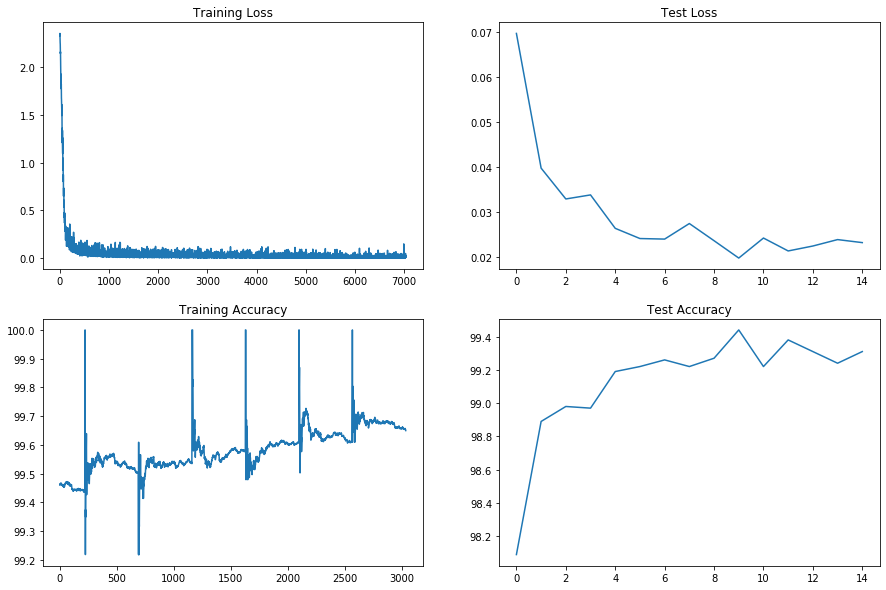

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")